# **Density Matrix Renormalization Group**


We employ the density matrix renormalization group (DMRG) algorithm
to optimize a matrix product state (MPS) such that it is the
eigenvector of lowest eigenvalue of a Hermitian matrix H.
The MPS `psi0` is used to initialize the MPS to be optimized,
and the `sweeps` object determines the parameters used to 
control the DMRG algorithm.

This version of `dmrg` accepts a representation of H as a
Vector of MPOs, Hs = [H1,H2,H3,...] such that H is defined
as H = H1+H2+H3+...
Note that this sum of MPOs is not actually computed; rather
the set of MPOs [H1,H2,H3,..] is efficiently looped over at 
each step of the DMRG algorithm when optimizing the MPS.


## Imports

In [1]:
#import Pkg
#Pkg.add(["ITensors", "IJulia", "Plots", "Random", "ITensorMPS"])

In [2]:
using ITensors, ITensorMPS, Random, Plots

# Heisenberg chain

We will now build the Heisenberg/XXZ chain. We run the DMRG while we log energy as we add sweeps. After that, we amy compare it to known thermodynamic limit ground state energy for $S=1/2$ Heisenberg chain and scan the maximal bond dimension $\chi$.

Now, a known reference (thermodynamic limit, $J=1$) for isotropic Heisenberg chain with $\Delta = 1$ is $e_0 = 1/4 - \ln 2 \approx -0.443$ (energy per site/bond).

In [4]:
# Building Heisenberg MPO with anisotropy

function heisenberg_xxz_mpo(N; delta=1.0)
    sites = siteinds("S=1/2", N)                # S^z eigenvalues ±1/2
    ampo = OpSum()
    for i in 1:N-1                               # open boundary
        ampo += 0.5, "S+", i, "S-", i+1
        ampo += 0.5, "S-", i, "S+", i+1
        ampo += delta,   "Sz", i, "Sz", i+1
    end
    return MPO(ampo, sites), sites
end

heisenberg_xxz_mpo (generic function with 1 method)

In [5]:
# Running DMRG incrementally, we record final energy after n sweeps

function dmrg_sweep_curve(H, sites; χ=128, maxsweeps=8, cutoff=1e-9, seed=42)
    Random.seed!(seed)
    psi = randomMPS(sites; linkdims=min(χ, 10))  # small random start; DMRG ramps up χ
    energies = Float64[]
    for ns = 1:maxsweeps
        sweeps = Sweeps(ns)
        maxdim!(sweeps, fill(χ, ns)...)
        cutoff!(sweeps, fill(cutoff, ns)...)
        # optional: addnoise!(sweeps, 1e-8, 1e-10, 2)  # can help avoid local minima
        E, psi = dmrg(H, psi, sweeps)
        push!(energies, E)
    end
    return energies, psi
end

dmrg_sweep_curve (generic function with 1 method)

In [6]:
# Running DMRG for a list of χ values (fixed # of sweeps each) and return energies.
function dmrg_vs_chi(H, sites; chis=[32, 64, 128, 256], sweeps_per_chi=6, cutoff=1e-9, seed=7)
    Es = Float64[]
    for (k, χ) in enumerate(chis)
        Random.seed!(seed)                       # comparable starts
        psi0 = randomMPS(sites; linkdims=min(χ, 10))
        sweeps = Sweeps(sweeps_per_chi)
        maxdim!(sweeps, fill(χ, sweeps_per_chi)...)
        cutoff!(sweeps, fill(cutoff, sweeps_per_chi)...)
        E, _ = dmrg(H, psi0, sweeps)
        push!(Es, E)
    end
    return Es
end

dmrg_vs_chi (generic function with 1 method)

### Heisenberg ($\Delta=1$), convergence vs. sweeps

After sweep 1 energy=-21.941892462941095  maxlinkdim=39 maxerr=9.63E-10 time=0.361
After sweep 1 energy=-21.971158104708312  maxlinkdim=54 maxerr=9.95E-10 time=0.673
After sweep 2 energy=-21.972107296823857  maxlinkdim=54 maxerr=9.98E-10 time=0.999
After sweep 1 energy=-21.972110143541897  maxlinkdim=52 maxerr=9.98E-10 time=0.994
After sweep 2 energy=-21.972110140674424  maxlinkdim=52 maxerr=9.89E-10 time=1.391
After sweep 3 energy=-21.97211014067158  maxlinkdim=52 maxerr=9.84E-10 time=1.746
After sweep 1 energy=-21.972110140665553  maxlinkdim=52 maxerr=9.84E-10 time=0.794
After sweep 2 energy=-21.97211014065371  maxlinkdim=52 maxerr=9.83E-10 time=0.781
After sweep 3 energy=-21.97211014064439  maxlinkdim=52 maxerr=9.83E-10 time=0.779
After sweep 4 energy=-21.972110140638005  maxlinkdim=52 maxerr=9.83E-10 time=0.899
After sweep 1 energy=-21.972110140632427  maxlinkdim=52 maxerr=9.83E-10 time=1.358
After sweep 2 energy=-21.972110140627713  maxlinkdim=52 maxerr=9.83E-10 time=0.738
After s

-0.4484104110330992

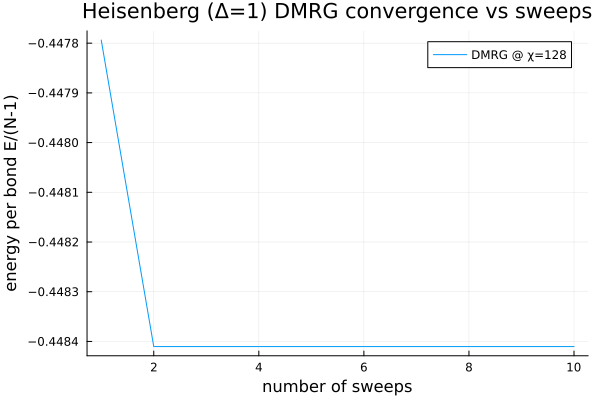

In [7]:
N  = 50                     
Δ  = 1.0
χ  = 128
maxsweeps = 10

H, sites = heisenberg_xxz_mpo(N; delta=Δ)
E_after_nsweeps, psi = dmrg_sweep_curve(H, sites; χ=χ, maxsweeps=maxsweeps, cutoff=1e-9)

e0 = 0.25 - log(2) # Bethe ansatz 
Epb = E_after_nsweeps ./ (N-1)

display(Epb[end])

plot(1:maxsweeps, Epb; xlabel="number of sweeps",ylabel="energy per bond E/(N-1)",label="DMRG @ χ=$(χ)", title="Heisenberg (Δ=1) DMRG convergence vs sweeps")


In [8]:
println("Bethe ansatz per-bond energy: ", e0)

Bethe ansatz per-bond energy: -0.4431471805599453


## H2 molecule

Using the Slater type orbital with 3 gaussians (STO-3G) basis, we build electron integrals in `pyscf`, then use load these integrals and feed them into a tensor network running DMRG.

In [9]:
using NPZ, Printf

In [10]:
NPZ_FILE = "../data/h2_sto3g_R0p74.npz"

@info "Loading integrals from $(NPZ_FILE)"
data = npzread(NPZ_FILE)
h1  = Array{Float64,2}(data["h1"])
eri = Array{Float64,4}(data["eri"])
eri = permutedims(eri, (1,3,2,4)) #physicist to chemist order

norb = size(h1,1)
sites = ITensorMPS.siteinds("Electron", norb; conserve_qns=true)

# Build Hamiltonian
os = OpSum()
for p=1:norb, q=1:norb
    h = h1[p,q]
    if abs(h) > 1e-12
        os += h, "Cdagup", p, "Cup", q
        os += h, "Cdagdn", p, "Cdn", q
    end
end
for p=1:norb, q=1:norb, r=1:norb, s=1:norb
    V = eri[p,q,r,s]
    if abs(V) > 1e-12
        os += 0.5*V, "Cdagup", p, "Cdagup", q, "Cup", s, "Cup", r   # same spin
        os += 0.5*V, "Cdagdn", p, "Cdagdn", q, "Cdn", s, "Cdn", r
        os += 0.5*V, "Cdagup", p, "Cdagdn", q, "Cdn", s, "Cup", r   # opposite spin
        os += 0.5*V, "Cdagdn", p, "Cdagup", q, "Cup", s, "Cdn", r
    end
end
H = ITensorMPS.MPO(os, sites)

# Closed-shell HF determinant: double occupancy of the lowest MO
psiHF = ITensorMPS.productMPS(sites, j -> j==1 ? "UpDn" : "Emp")

sweeps = ITensorMPS.Sweeps(6)
ITensorMPS.maxdim!(sweeps, 50, 100, 200, 400, 800, 1000)
ITensorMPS.mindim!(sweeps, 10, 20, 20, 20, 20, 20)
ITensorMPS.cutoff!(sweeps, 1e-12)
ITensorMPS.noise!(sweeps, 1e-7, 1e-8, 1e-10, 0, 1e-11, 0)

@info "Running DMRG..."
E, psi = ITensorMPS.dmrg(H, psiHF, sweeps; outputlevel=0)
@info @sprintf("DMRG (electronic) = %.12f Ha", E) 

# 1-RDM and NOs
function one_rdm_spin_summed(psi::MPS, sites, norb)
    gamma = zeros(norb, norb)
    for p=1:norb, q=1:norb
        os = OpSum()
        os += 1.0,"Cdagup",p,"Cup",q
        os += 1.0,"Cdagdn",p,"Cdn",q
        gamma[p,q] = ITensorMPS.inner(psi, ITensorMPS.MPO(os, sites), psi)
    end
    return (gamma + gamma')/2
end

gamma = one_rdm_spin_summed(psi, sites, norb)
vals, vecs = eigen(gamma); perm = sortperm(vals; rev=true)
no_occ = vals[perm]; U_no = vecs[:,perm]
npzwrite("../data/h2_no_from_dmrg.npz", Dict("gamma"=>gamma, "no_occ"=>no_occ, "U_no"=>U_no, "E_dmrg"=>E))
@info("Saved natural orbital from DMRG in ../data/h2_no_from_dmrg.npz") 


[ Info: Loading integrals from ../data/h2_sto3g_R0p74.npz
[ Info: Running DMRG...
[ Info: DMRG (electronic) = -1.852388173570 Ha
┌ Warning: Calling `inner(x::MPS, A::MPO, y::MPS)` where the site indices of the `MPS`
│ `x` and the `MPS` resulting from contracting `MPO` `A` with `MPS` `y` don't
│ match is deprecated as of ITensors v0.3 and will result in an error in ITensors
│ v0.4. The most common cause of this is something like the following:
│ 
│ ```julia
│ s = siteinds("S=1/2")
│ psi = random_mps(s)
│ H = MPO(s, "Id")
│ inner(psi, H, psi)
│ ```
│ 
│ `psi` has the Index structure `-s-(psi)` and `H` has the Index structure
│ `-s'-(H)-s-`, so the Index structure of would be `(dag(psi)-s- -s'-(H)-s-(psi)`
│  unless the prime levels were fixed. Previously we tried fixing the prime level
│   in situations like this, but we will no longer be doing that going forward.
│ 
│ There are a few ways to fix this. You can simply change:
│ 
│ ```julia
│ inner(psi, H, psi)
│ ```
│ 
│ to:
│ 
│ ```julia

In [11]:
# exact ground-state energy via Qiskit
function numpy_exact_energy(h1::Array{Float64,2}, eri::Array{Float64,4})
    qn_ham   = pyimport("qiskit_nature.second_q.hamiltonians")
    qn_prob  = pyimport("qiskit_nature.second_q.problems")
    qn_map   = pyimport("qiskit_nature.second_q.mappers")
    qa       = pyimport("qiskit_algorithms")
    builtins = pyimport("builtins")

    # Build qubit Hamiltonian
    ham     = qn_ham.ElectronicEnergy.from_raw_integrals(h1, eri)
    problem = qn_prob.ElectronicStructureProblem(ham)
    mapper  = qn_map.JordanWignerMapper()
    Hq      = mapper.map(problem.hamiltonian.second_q_op())

    # Exact (FCI in active space)
    solver  = qa.NumPyMinimumEigensolver()
    res     = solver.compute_minimum_eigenvalue(Hq)
    E       = builtins.float(res.eigenvalue) |> Float64
    return E
end


function tn_active_space(h1_full::Array{Float64,2},eri_full::Array{Float64,4},U_no::Array{Float64,2},occ::Vector{Float64},K::Int)
    np = pyimport("numpy")
    keep = sort(collect(view(sortperm(abs.(occ .- 1.0)), 1:K)))  # indices of K NOs
    U_act = U_no[:, keep]                            
    h1a   = transpose(U_act) * h1_full * U_act
    eria  = np.einsum("Pa,Qb,Rc,Sd,ABCD->PQRS",U_act, U_act, U_act, U_act, eri_full;optimize=true) |> Array{Float64,4}
    return h1a, eria, keep, U_act
end

tn_active_space (generic function with 1 method)

In [12]:
using PyCall

In [13]:
function main(; K_ACTIVE::Int = 6,npz_full::String = "../data/h2_ccpvdz_R0p74.npz", npz_no::String   = "../data/h2_ccpvdz_no_from_dmrg.npz")

    full = npzread(npz_full)
    h1_full  = Array{Float64,2}(full["h1"])
    eri_full = Array{Float64,4}(full["eri"])                
    mo_e     = haskey(full, "mo_energy") ? Array{Float64,1}(full["mo_energy"]) : Array{Float64,1}(full["mo_e"])
    e_nuc    = Float64(full["e_nuc"])
    norb_full = size(h1_full,1)
    @assert size(eri_full) == (norb_full, norb_full, norb_full, norb_full)
    tn = npzread(npz_no)
    U_no  = Array{Float64,2}(tn["U_no"])          
    occ   = Array{Float64,1}(tn["no_occ"])        
    E_dmrg_full = Float64(tn["E_dmrg"])           

    @assert size(U_no) == (norb_full, norb_full)

    @info "Full cc-pVDZ orbitals = $norb_full  | Active K = $K_ACTIVE"
    @info "Sum of active NO occupations ≈ $(sum(occ[sortperm(abs.(occ .- 1.0))[1:K_ACTIVE]]))"

    h1_no, eri_no, keep_no, U_act_no = tn_active_space(h1_full, eri_full, U_no, occ, K_ACTIVE)
    @info "Active NO indices = $(keep_no)"

    # exact energy (active space) via Qiskit
    E_exact_NO = numpy_exact_energy(h1_no, eri_no)

    # pick K canonical orbitals nearest the HOMO/LUMO mid-energy
    eps = mo_e
    homo = sortperm(eps)[1]   
    lumo = sortperm(eps)[2]
    mu   = 0.5*(eps[homo] + eps[lumo])
    keep_can = sortperm(abs.(eps .- mu))[1:K_ACTIVE] |> sort
    U_act_can = Matrix{Float64}(I, norb_full, norb_full)[:, keep_can]
    h1_can = transpose(U_act_can) * h1_full * U_act_can
    np = pyimport("numpy")
    eri_can = np.einsum("Pa,Qb,Rc,Sd,ABCD->PQRS",U_act_can, U_act_can, U_act_can, U_act_can, eri_full;optimize=true) |> Array{Float64,4}
    E_exact_CAN = numpy_exact_energy(h1_can, eri_can)

    @info @sprintf("Exact (Qiskit, TN-NO active)  = %.12f Ha", E_exact_NO)
    @info @sprintf("Exact (Qiskit, Canon. active) = %.12f Ha", E_exact_CAN)
    @info @sprintf("DMRG (full 10-orb electronic) = %.12f Ha", E_dmrg_full)
    return (; E_exact_NO, E_exact_CAN, E_dmrg_full, h1_no, eri_no, keep_no, h1_can, eri_can, keep_can, e_nuc)
end

main()

[ Info: Full cc-pVDZ orbitals = 10  | Active K = 6
[ Info: Sum of active NO occupations ≈ 1.9834479388687853
[ Info: Active NO indices = [1, 2, 3, 4, 5, 6]


LoadError: PyError (PyImport_ImportModule

The Python package qiskit_nature.second_q.hamiltonians could not be imported by pyimport. Usually this means
that you did not install qiskit_nature.second_q.hamiltonians in the Python version being used by PyCall.

PyCall is currently configured to use the Python version at:

/home/david/repos/TN/.venv/bin/python

and you should use whatever mechanism you usually use (apt-get, pip, conda,
etcetera) to install the Python package containing the qiskit_nature.second_q.hamiltonians module.

One alternative is to re-configure PyCall to use a different Python
version on your system: set ENV["PYTHON"] to the path/name of the python
executable you want to use, run Pkg.build("PyCall"), and re-launch Julia.

Another alternative is to configure PyCall to use a Julia-specific Python
distribution via the Conda.jl package (which installs a private Anaconda
Python distribution), which has the advantage that packages can be installed
and kept up-to-date via Julia.  As explained in the PyCall documentation,
set ENV["PYTHON"]="", run Pkg.build("PyCall"), and re-launch Julia. Then,
To install the qiskit_nature.second_q.hamiltonians module, you can use `pyimport_conda("qiskit_nature.second_q.hamiltonians", PKG)`,
where PKG is the Anaconda package that contains the module qiskit_nature.second_q.hamiltonians,
or alternatively you can use the Conda package directly (via
`using Conda` followed by `Conda.add` etcetera).

) <class 'ImportError'>
ImportError("cannot import name 'BaseSampler' from 'qiskit.primitives' (/home/david/repos/TN/.venv/lib/python3.12/site-packages/qiskit/primitives/__init__.py)")
  File "/home/david/repos/TN/.venv/lib/python3.12/site-packages/qiskit_nature/__init__.py", line 53, in <module>
    from qiskit_algorithms.list_or_dict import ListOrDict as ListOrDictType
  File "/home/david/repos/TN/.venv/lib/python3.12/site-packages/qiskit_algorithms/__init__.py", line 254, in <module>
    from .variational_algorithm import VariationalAlgorithm, VariationalResult
  File "/home/david/repos/TN/.venv/lib/python3.12/site-packages/qiskit_algorithms/variational_algorithm.py", line 36, in <module>
    from .optimizers import OptimizerResult
  File "/home/david/repos/TN/.venv/lib/python3.12/site-packages/qiskit_algorithms/optimizers/__init__.py", line 139, in <module>
    from .qnspsa import QNSPSA
  File "/home/david/repos/TN/.venv/lib/python3.12/site-packages/qiskit_algorithms/optimizers/qnspsa.py", line 23, in <module>
    from qiskit.primitives import BaseSampler
